In [1]:
import sys
import time
import numpy as np
import pylab as pl

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module
from vent.common.message import SensorValues, ControlSetting, Alarm, AlarmSeverity
from vent.common.values import ValueName, CONTROL

In [2]:
Controller = get_control_module(sim_mode=True)

In [3]:
Controller.start()

ls = []
tt = []
t0 = time.time()
for t in np.arange(0, 3600,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        print(Controller.heartbeat())
    
    
    ## Do things
    
    
    ##
    
    
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time()  - t0)
    
    time.sleep(0.05)
    
Controller.stop()

0
473
947
1412
1876
2339
2803
3265
3731
4198
4660
5120
5581
6040
6501
6964
7422
7890
8353
8813
9272
9735
10194
10654
11110
11568
12033
12491
12956
13415
13873
14334
14795
15255
15719
16179
16646
17104
17567
18030
18494
18955
19416
19877
20336
20798
21258
21719
22181
22638
23101
23561
24019
24479
24941
25403
25866
26328
26784
27248
27710
28168
28625
29085
29548
30008
30475
30928
31379
31829
32280
32728
33177
33629
34077
34525
34972
35419
35868
36316
36770
37229
37678
38136
38584
39033
39484
39939
40403
40860
41320
41772
42211
42654
43104
43564
44018
44472
44938
45403
45871
46337
46811
47274
47740
48205
48671
49136
49604
50071
50542
51011
51474
51938
52404
52868
53337
53808
54271
54738
55202
55668
56133
56601
57072
57536
58000
58469
58936
59403
59866
60326
60793
61257
61719
62177
62635
63093
63556
64023
64487
64951
65416
65882
66346
66812
67280
67742
68206
68669
69135
69599
70064
70533
71004
71468
71935
72400
72863
73327
73791
74254
74726
75192
75652
76113
76575
77039
77503
77968
78435
7

Text(0.5, 0, 'time [s]')

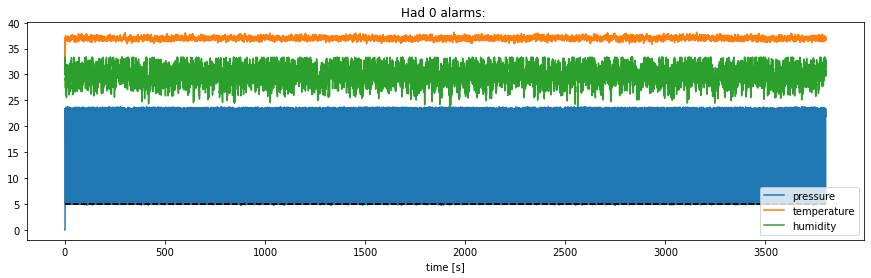

In [5]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ValueName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ValueName.PEEP)
pip = cc.value

pl.plot(tt, [s.pressure for s in ls], label = 'pressure')
pl.plot(tt, [s.temp for s in ls], label = "temperature")
pl.plot(tt, [s.humidity/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

active_alarms = Controller.get_active_alarms()
logged_alarms = Controller.get_logged_alarms()

pc = 0
for active_alarm_key in active_alarms.keys():
    alarm = active_alarms[active_alarm_key]
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25], 'r-')
    pc += 0.1

pc=0
for alarm in logged_alarms:
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25-7*pc], 'b-')
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_end_time-t0+pc],  [25-7*pc,25-7*pc], 'b-')
    pc += 0.1

s = "Had " + str(len(Controller.get_alarms())) + " alarms: "
for alarm in Controller.get_alarms():
    s = s + alarm.alarm_name + ", "
    
pl.title(s)
pl.legend()
pl.xlabel("time [s]")